# Neural Network Performance Visualization

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from src.custom_nn import CustomNeuralNet, train_model, setup_device  

## 1️⃣ Prepare MNIST dataset

In [23]:
device = setup_device()

train_data = datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root="data", train=False, transform=transforms.ToTensor(), download=True)

mean = train_data.data.float().mean() / 255.0
std = train_data.data.float().std() / 255.0
print(f"Train data mean: {mean:.4f}, std: {std:.4f}")

X_train = ((train_data.data.view(-1, 28*28).float() / 255.0 - mean) / std).to(device)
y_train = (train_data.targets).to(device)

X_test = ((test_data.data.view(-1, 28*28).float() / 255.0 - mean) / std).to(device)
y_test = (test_data.targets).to(device)

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Utilizing device: cuda:0
Train data mean: 0.1307, std: 0.3081
Train data shape: torch.Size([60000, 784])
Train labels shape: torch.Size([60000])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000])


## 2️⃣ Define model and train

In [ ]:
model = CustomNeuralNet(
    sizes=[28*28, 128, 64, 10],  # input → hidden1 → hidden2 → output
    activation=nn.ReLU,
    weight_init="he"
)

train_model(
    model,
    X=X_train,
    y=y_train,
    epochs=30,
    batch=64,
    lr=0.01,
    val_fraction=0.3,
    patience=5
)


## 3️⃣ Load results.csv for visualization

In [4]:
csv_path = os.path.join("model1", "results.csv")
results = pd.read_csv(csv_path)

results.head()

,epoch,train_loss,val_loss,train_acc,val_acc,train_std,val_std
0,1,0.535764,0.311580,0.840357,0.904833,0.404488,0.097451
1,2,0.256632,0.253979,0.925762,0.922444,0.091679,0.091255
2,3,0.204804,0.222912,0.941452,0.934111,0.084033,0.087833
3,4,0.173411,0.194304,0.951238,0.943167,0.077791,0.086038
4,5,0.150891,0.172998,0.957000,0.948222,0.069916,0.079991


## 4️⃣ Plot Training and Validation Loss over Epochs

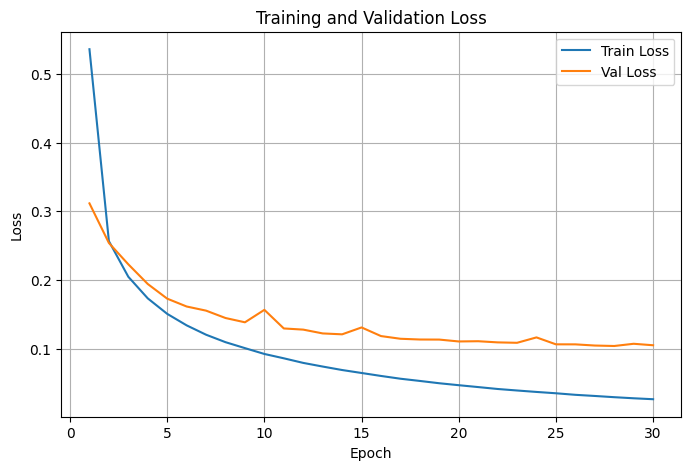

In [5]:
plt.figure(figsize=(8,5))
plt.plot(results["epoch"], results["train_loss"], label="Train Loss")
plt.plot(results["epoch"], results["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## 5️⃣ Plot Training and Validation Accuracy over Epochs

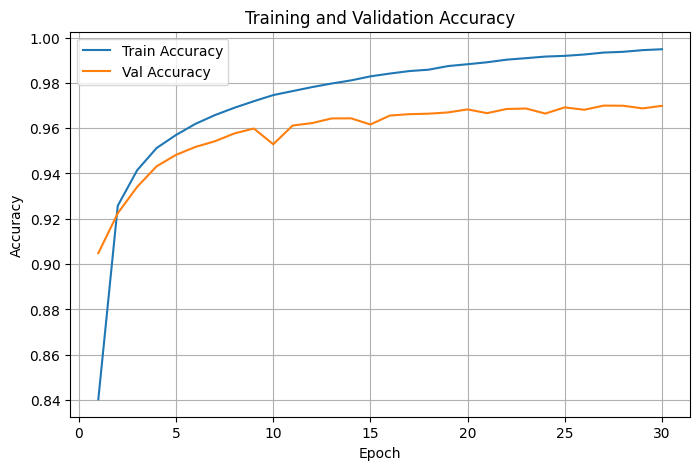

In [6]:
plt.figure(figsize=(8,5))
plt.plot(results["epoch"], results["train_acc"], label="Train Accuracy")
plt.plot(results["epoch"], results["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## 6️⃣ Learning curves with error bars

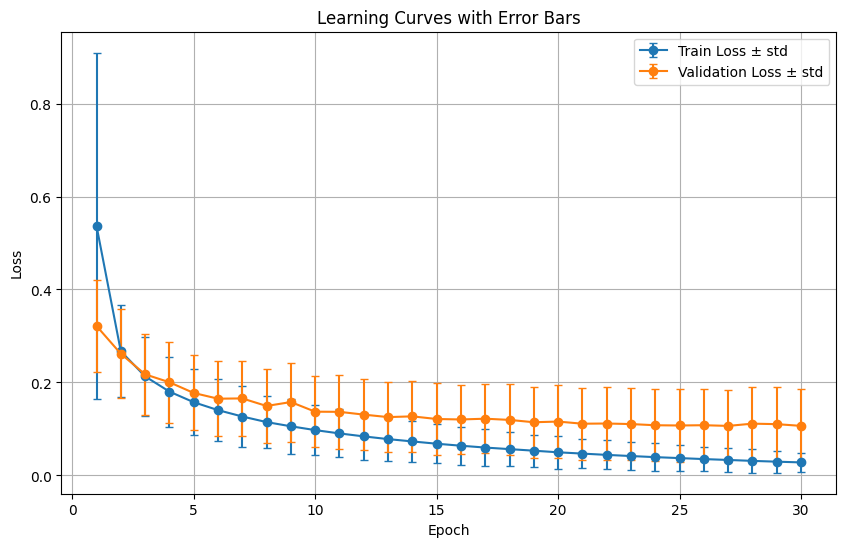

In [8]:
epochs = results['epoch']
train_loss = results['train_loss']
val_loss = results['val_loss']
train_std = results['train_std']
val_std = results['val_std']

plt.figure(figsize=(10,6))
plt.errorbar(epochs, train_loss, yerr=train_std, label="Train Loss ± std", fmt='-o', capsize=3)
plt.errorbar(epochs, val_loss, yerr=val_std, label="Validation Loss ± std", fmt='-o', capsize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves with Error Bars")
plt.legend()
plt.grid(True)
plt.show()

## 7️⃣ Convergence Analysis

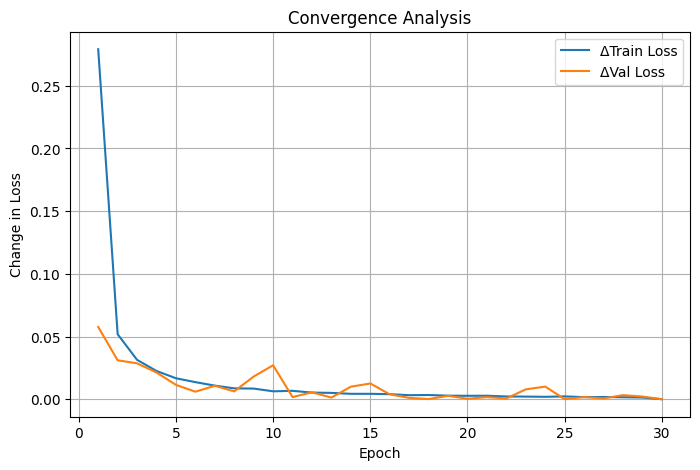

In [8]:
epochs = results['epoch']
train_loss = results['train_loss']
val_loss = results['val_loss']

plt.figure(figsize=(8,5))
plt.plot(epochs, np.abs(np.diff([*train_loss, train_loss.iloc[-1]])), label="ΔTrain Loss")
plt.plot(epochs, np.abs(np.diff([*val_loss, val_loss.iloc[-1]])), label="ΔVal Loss")
plt.xlabel("Epoch")
plt.ylabel("Change in Loss")
plt.title("Convergence Analysis")
plt.legend()
plt.grid(True)
plt.show()

## 8️⃣ Model Evaluation

#### Load best model

In [ ]:
best_model = CustomNeuralNet(
    sizes=[28*28, 128, 64, 10],
    activation=nn.ReLU,
    weight_init="he"
)

path = os.path.join("model1", "weights", "best.pt")
checkpoint = torch.load(path, map_location=device)
best_model.load_state_dict(checkpoint['model_state'])
best_model.to(device)
best_model.eval()

#### Predict on a single test image

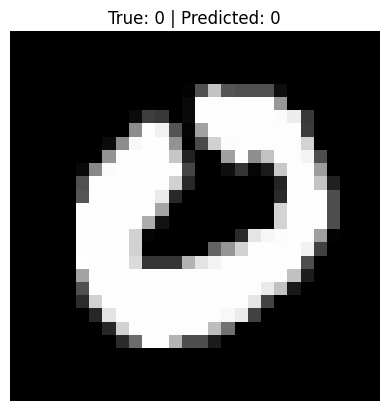

In [30]:
# Pick a single test image
idx = 25
x_sample = X_test[idx].unsqueeze(0)  # shape [1, 784]
y_true = y_test[idx].item()

# Make prediction
with torch.no_grad():
    outputs = best_model(x_sample)
    _, pred = torch.max(outputs, 1)

# Display image and prediction
plt.imshow(X_test[idx].view(28, 28).cpu(), cmap="gray")
plt.title(f"True: {y_true} | Predicted: {pred.item()}")
plt.axis("off")
plt.show()

#### Evaluate accuracy on the full test set

In [31]:
correct = 0
total = 0

best_model.eval()
with torch.no_grad():
    outputs = best_model(X_test.to(device))
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9723
